# Classification of b-quark jets in the Aleph simulated data

Python macro for selecting b-jets in Aleph Z->qqbar MC in various ways:
* Initially, simply with "if"-statements making requirements on certain variables. This corresponds to selecting "boxes" in the input variable space (typically called "X"). One could also try a Fisher discriminant (linear combination of input variables), which corresponds to a plane in the X-space. But as the problem is non-linear, it is likely to be sub-optimal.

* Next using Machine Learning (ML) methods. We will try both tree based and Neural Net (NN) based methods, and see how complicated (or not) it is to get a good solution, and how much better it performs compared to the "classic" selection method.

In the end, this exercise is the simple start on moving into the territory of multidimensional analasis.

### Data:
The input variables (X) are:
* energy: Measured energy of the jet in GeV. Should be 45 GeV, but fluctuates.
* cTheta: cos(theta), i.e. the polar angle of the jet with respect to the beam axis.
          The detector works best in the central region (|cTheta| small) and less well in the forward regions.
* phi:    The azimuth angle of the jet. As the detector is uniform in phi, this should not matter (much).
* prob_b: Probability of being a b-jet from the pointing of the tracks to the vertex.
* spheri: Sphericity of the event, i.e. how spherical it is.
* pt2rel: The transverse momentum squared of the tracks relative to the jet axis, i.e. width of the jet.
* multip: Multiplicity of the jet (in a relative measure).
* bqvjet: b-quark vertex of the jet, i.e. the probability of a detached vertex.
* ptlrel: Transverse momentum (in GeV) of possible lepton with respect to jet axis (about 0 if no leptons).

The target variable (Y) is:
* isb:    1 if it is from a b-quark and 0, if it is not.

Finally, those before you (the Aleph collaboration in the mid 90'ies) produced a Neural Net based classification variable, which you can compare to (and compete with?):
* nnbjet: Value of original Aleph b-jet tagging algorithm (for reference).


### Task:
Thus, the task before you is to produce a function (ML algorithm), which given the input variables X provides an output variable estimate, Y_est, which is "closest possible" to the target variable, Y. The "closest possible" is left to the user to define in a _Loss Function_, which we will discuss further. In classification problems (such as this), the typical loss function to use "Cross Entropy", see https://en.wikipedia.org/wiki/Cross_entropy.


* Author: Troels C. Petersen (NBI)
* Email:  petersen@nbi.dk
* Date:   31st of April 2021

In [1]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import numpy as np
import csv

import pandas as pd 
from pandas import Series, DataFrame 
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

import time

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


Possible other packages to consider:
cornerplot, seaplot, sklearn.decomposition(PCA)

In [2]:
r = np.random
r.seed(42)

SavePlots = False
plt.close('all')

***

# Classify B-jets using LightGBM:

This is a solution example using LightGBM (tree based) and MLPclassifier (NN based).

In [3]:
# Read the data in using Pandas Dataframe and print the variables:
data = pd.DataFrame(np.genfromtxt('AlephBtag_MC_small_v2.csv', names=True))
variables = data.columns
print(variables)

Index(['energy', 'cTheta', 'phi', 'prob_b', 'spheri', 'pt2rel', 'multip',
       'bqvjet', 'ptlrel', 'nnbjet', 'isb'],
      dtype='object')


In [4]:
start=time.time()

# Decide on which variables to use for input (X) and what defines the label (Y):
input_variables = variables[(variables != 'nnbjet') & (variables != 'isb')]
input_data      = data[input_variables]
truth_data      = data['isb']
benchmark_data  = data['nnbjet']
print("  Variables used for training: ", input_variables)

# Split data set into training and test set and feed these to LightGBM:
input_train, input_test, truth_train, truth_test, benchmark_train, benchmark_test = train_test_split(input_data, truth_data, benchmark_data, test_size=0.25, random_state=42)
lgb_train = lgb.Dataset(input_train, truth_train)
lgb_eval  = lgb.Dataset(input_test,  truth_test, reference=lgb_train)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'num_leaves': 20,
}

# Train the model:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                early_stopping_rounds=50)

# Make predictions:
y_score = gbm.predict(input_test, num_iteration=gbm.best_iteration)
y_pred  = [1 if pred > 0.5 else 0 for pred in y_score]

# Print the time usage:
end = time.time()
print(f"Time used by LightGBM: {(end-start)*1000:.1f} ms")

  Variables used for training:  Index(['energy', 'cTheta', 'phi', 'prob_b', 'spheri', 'pt2rel', 'multip',
       'bqvjet', 'ptlrel'],
      dtype='object')
[1]	valid_0's binary_logloss: 0.485001
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.448637
[3]	valid_0's binary_logloss: 0.420096
[4]	valid_0's binary_logloss: 0.397495
[5]	valid_0's binary_logloss: 0.3785
[6]	valid_0's binary_logloss: 0.362879
[7]	valid_0's binary_logloss: 0.349525
[8]	valid_0's binary_logloss: 0.337686
[9]	valid_0's binary_logloss: 0.327579
[10]	valid_0's binary_logloss: 0.318867
[11]	valid_0's binary_logloss: 0.311337
[12]	valid_0's binary_logloss: 0.304539
[13]	valid_0's binary_logloss: 0.298589
[14]	valid_0's binary_logloss: 0.293481
[15]	valid_0's binary_logloss: 0.288499
[16]	valid_0's binary_logloss: 0.284442
[17]	valid_0's binary_logloss: 0.280641
[18]	valid_0's binary_logloss: 0.277102
[19]	valid_0's binary_logloss: 0.274052
[20]	valid_0's binary_logloss: 0.2

Text(0, 0.5, 'True Positive Rate')

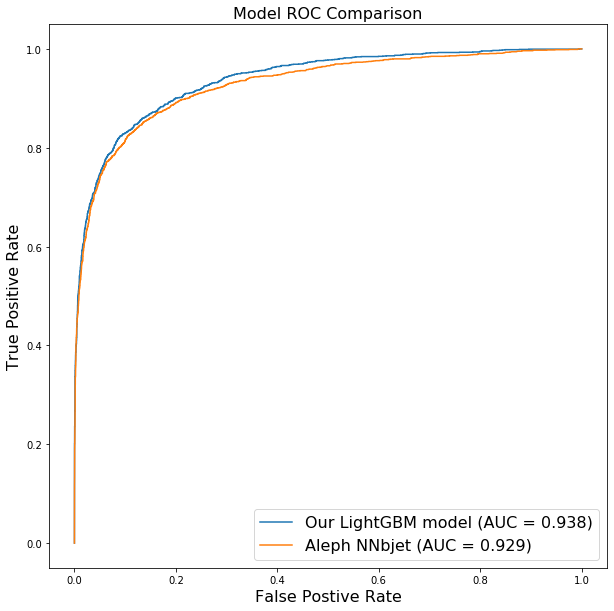

In [5]:
# Evaluate:
fpr, tpr, _ = roc_curve(truth_test, y_score)                  # False/True Positive Rate for our model
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(truth_test, benchmark_test)  # False/True Positive Rate for Aleph NNbjet

# We can now calculate the AUC scores of these ROC-curves:
auc_score = auc(fpr,tpr)                        # This is the AUC score for our model
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)  # This is the AUC score for Aleph NNbjet

# Let's plot the ROC curves for these results:
fig = plt.figure(figsize = [10,10])
plt.title('Model ROC Comparison', size = 16)
plt.plot(fpr, tpr, label=f'Our LightGBM model (AUC = {auc_score:5.3f})')
plt.plot(fpr_nnbjet, tpr_nnbjet, label = f'Aleph NNbjet (AUC = {auc_score_nnbjet:5.3f})')
plt.legend(fontsize=16)
plt.xlabel('False Postive Rate', size=16)
plt.ylabel('True Positive Rate', size=16)

# This just plots a table with the AUC-scores.
#row_labels=['Our model', 'Aleph NNbjet']
#table_vals=[[round(auc_score,5)], [round(auc_score_nnbjet,5)]]
#col_labels=['AUC']
#the_table = plt.table(cellText=table_vals,
#                  colWidths = [0.1]*3,
#

In [31]:
from sklearn.neural_network import MLPClassifier

start=time.time()
clf = MLPClassifier(max_iter=20000,
                    n_iter_no_change=100,           # Number of iterations without improvement before stopping
                    solver='adam',                  # Standard for minimising
                    activation='logistic',          # Standard function (but slightly slower)
                    hidden_layer_sizes=(10, 10),    # Size of network
                    learning_rate='invscaling',     # Other options are "constant" and "adaptive"
                    random_state=42)
clf.fit(input_test, truth_test)

# Make predictions (NOTE: This "spits out" two columns!):
y_score_MLP = clf.predict_proba(input_test)

# Print the time usage:
end = time.time()
print(f"Time used by MLPClassifier: {(end-start)*1000:.1f} ms")

Time used by MLPClassifier: 8793.2 ms


Text(0, 0.5, 'True Positive Rate')

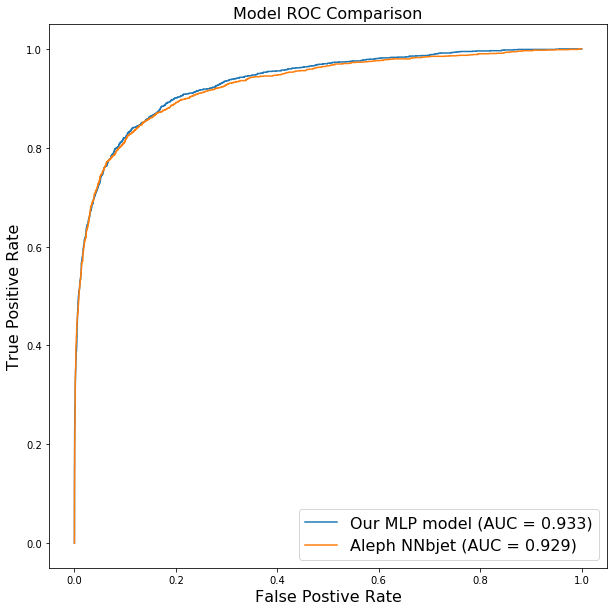

In [32]:
# Evaluate:
fpr, tpr, _ = roc_curve(truth_test, y_score_MLP[:,1])              # False/True Positive Rate for our model
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(truth_test, benchmark_test)  # False/True Positive Rate for Aleph NNbjet

# We can now calculate the AUC scores of these ROC-curves:
auc_score = auc(fpr,tpr)                        # This is the AUC score for our model
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)  # This is the AUC score for Aleph NNbjet

# Let's plot the ROC curves for these results:
fig = plt.figure(figsize = [10,10])
plt.title('Model ROC Comparison', size = 16)
plt.plot(fpr, tpr, label=f'Our MLP model (AUC = {auc_score:5.3f})')
plt.plot(fpr_nnbjet, tpr_nnbjet, label = f'Aleph NNbjet (AUC = {auc_score_nnbjet:5.3f})')
plt.legend(fontsize=16)
plt.xlabel('False Postive Rate', size=16)
plt.ylabel('True Positive Rate', size=16)